# YouTube Comments Sentiment Analysis 
Spring 2018


## 1 Set Up

### 1.1 Import Basic Modules

In [99]:
# Basics
import pandas as pd; import os
import csv; import numpy as np
import re; import warnings
warnings.filterwarnings('ignore')

### 1.2 Read In Data

In [100]:
os.chdir('/Users/andiedonovan/myProjects/Youtube_Python_Project/AndiesBranch/') # change directory

In [101]:
df = pd.read_csv('data/data.csv', delimiter="@@@", skiprows=2, encoding='utf-8', engine='python')

#### Pre-Labeled YouTube Data

In [102]:
# training data
okgo = pd.read_csv('data/OKGO.csv', delimiter=";", skiprows=2, encoding='latin-1', engine='python') # read in the data
trump = pd.read_csv('data/trump.csv', delimiter=",", skiprows=2, encoding='utf-8', error_bad_lines=False, engine='python')
swift = pd.read_csv('data/TaylorSwift.csv', delimiter=",", skiprows=2, nrows=180, encoding='utf-8', engine='python')
royal = pd.read_csv('data/RoyalWedding.csv', delimiter=",", skiprows=2, nrows=61, encoding='utf-8', engine='python')
paul = pd.read_csv('data/LoganPaul.csv', delimiter=",", skiprows=2, nrows=200, encoding='utf-8', engine='python')
blogs = pd.read_csv('data/Kagel.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data
tweets = pd.read_csv('data/twitter.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data

#### Non-YouTube Data

In [103]:
blogs = pd.read_csv('data/Kagel.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data
tweets = pd.read_csv('data/twitter.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data

### 1.3 Clean Data Columns

In [104]:
# clean dataframes
tweets = tweets.drop(['Topic', 'TweetId', "TweetDate"], axis = 1).dropna()

In [105]:
def fix_cols(DF):
    DF = DF.iloc[:,:2]
    DF.columns = ["label", "comment"]
    return DF

In [106]:
okgo = fix_cols(okgo)
trump = fix_cols(trump)
swift = fix_cols(swift)
royal = fix_cols(royal)
paul = fix_cols(paul)
tweets = fix_cols(tweets)

In [107]:
tweets.label = tweets.label.replace({'positive': '1.0', 'negative':'-1.0', 'neutral': '0.0', 'irrelevant': '0.0'}, regex=True)
tweets['label'] = pd.to_numeric(tweets['label'], errors='coerce')

### 1.3.b Create Datasets

In [108]:
videos = pd.concat([okgo, trump, swift, royal, paul], ignore_index=True)
data = videos.copy()
data = fix_cols(data)

In [109]:
videos = pd.concat([okgo, trump, swift, royal, paul], ignore_index=True)
full = pd.concat([okgo, trump, swift, royal, paul, blogs, tweets], ignore_index=False)
videos_not_okgo = pd.concat([trump, swift, royal, paul], ignore_index=False)
videos_not_royal = pd.concat([okgo, trump, swift, paul], ignore_index=False)

In [110]:
'''DataList = [videos, full, videos_not_royal, videos_not_okgo]
excluded = [okgo, royal]'''

'DataList = [videos, full, videos_not_royal, videos_not_okgo]\nexcluded = [okgo, royal]'

In [111]:
df.columns = ["comment", "label"]

In [112]:
videos.head(3)

,label,comment
0,-1.0,Everyone knows brand's papers from.\nBut -No o...
1,0.0,ÒYour paper cut balance is: \n-£25279102771Ó
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE.........


In [113]:
df.head(3)

,comment,label
0,why the fuck does this look fake,NaN
1,3 it so cool,NaN
2,Im so confused,NaN


### 1.4 Remove Non-Alphabetic Characters (including numbers)

In [114]:
def AsStr(DF):
    DF["comment"]= DF["comment"].astype(str) 

'''for i in range(0, len(DataList)): 
    AsStr(DataList[i])'''

'for i in range(0, len(DataList)): \n    AsStr(DataList[i])'

In [115]:
'''for i in range(0, len(excluded)): 
    AsStr(excluded[i])'''
    
AsStr(df)
AsStr(data)

In [116]:
def cleanerFn(b):
    for row in range(len(b)):
        line = b.loc[row, "comment"]
        b.loc[row,"comment"] = re.sub("[^a-zA-Z]", " ", line)

In [117]:
data.head(3)

,label,comment
0,-1.0,Everyone knows brand's papers from.\nBut -No o...
1,0.0,ÒYour paper cut balance is: \n-£25279102771Ó
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE.........


In [118]:
cleanerFn(df)
cleanerFn(data)

In [119]:
'''for i in range(0, len(excluded)): 
    cleanerFn(excluded[i])'''

'for i in range(0, len(excluded)): \n    cleanerFn(excluded[i])'

## 2 Natural Language Processing

### 2.1 Import Packages

In [120]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [121]:
sw = stopwords.words('english')
nltk.download('stopwords')
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andiedonovan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.2 Tokenize Words

In [122]:
df['com_token']=df['comment'].str.lower().str.split()

### 2.3 Remove Stop Words, Lemmatization, Stemming

In [123]:
def nlpFunction(DF):
    DF['com_token'] = DF['comment'].str.lower().str.split()
    DF['com_remv'] = DF['com_token'].apply(lambda x: [y for y in x if y not in sw])
    DF["com_lemma"] = DF['com_remv'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization
    DF['com_stem'] = DF['com_lemma'].apply(lambda x : [ps.stem(y) for y in x]) # stemming
    DF["com_tok_str"] = DF["com_stem"].apply(', '.join)
    DF["com_full"] = DF["com_stem"].apply(' '.join)
    #DF["com_tagged"] = DF['comment'].apply(lambda x : [nltk.pos_tag(y) for y in x]) #word tagging
    return DF

In [124]:
'''for i in range(0, len(DataList)): 
    nlpFunction(DataList[i])'''

'for i in range(0, len(DataList)): \n    nlpFunction(DataList[i])'

In [125]:
'''for i in range(0, len(excluded)): 
    nlpFunction(excluded[i])'''

'for i in range(0, len(excluded)): \n    nlpFunction(excluded[i])'

In [126]:
df = nlpFunction(df)
data = nlpFunction(data)
#trump = nlpFunction(trump)

In [127]:
data = data.dropna()

In [128]:
data.head(3)

,label,comment,com_token,com_remv,com_lemma,com_stem,com_tok_str,com_full
0,-1.0,Everyone knows brand s papers from But No on...,"[everyone, knows, brand, s, papers, from, but,...","[everyone, knows, brand, papers, one, knows, w...","[everyone, know, brand, paper, one, know, welf...","[everyon, know, brand, paper, one, know, welfa...","everyon, know, brand, paper, one, know, welfar...",everyon know brand paper one know welfar emplo...
1,0.0,Your paper cut balance is,"[your, paper, cut, balance, is]","[paper, cut, balance]","[paper, cut, balance]","[paper, cut, balanc]","paper, cut, balanc",paper cut balanc
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE ...,"[oh, shit, when, i, saw, this, on, my, front, ...","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","oh, shit, saw, front, page, love, song",oh shit saw front page love song


In [129]:
df.head(3)

,comment,label,com_token,com_remv,com_lemma,com_stem,com_tok_str,com_full
0,why the fuck does this look fake,NaN,"[why, the, fuck, does, this, look, fake]","[fuck, look, fake]","[fuck, look, fake]","[fuck, look, fake]","fuck, look, fake",fuck look fake
1,it so cool,NaN,"[it, so, cool]",[cool],[cool],[cool],cool,cool
2,Im so confused,NaN,"[im, so, confused]","[im, confused]","[im, confused]","[im, confus]","im, confus",im confus


## 3 Data Transformations

### 3.1 Split into Training and Test Data

In [130]:
import sklearn # machine learning
from sklearn.model_selection import train_test_split # splitting up 

In [131]:
X_train = data["com_tok_str"]
#X_test = trump["com_stem_str"]
Y_train = data["label"]
#Y_test = trump["label"]
X_user = df["com_tok_str"]

In [132]:
videos = videos.dropna(axis=0)
videos_not_okgo = videos_not_okgo.dropna(axis=0)
videos_not_royal = videos_not_royal.dropna(axis=0)
royal = royal.dropna(axis=0)
okgo = okgo.dropna(axis=0)
full = full.dropna(axis=0)

In [133]:
'''x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(
    full["com_stem_str"], full["label"], test_size=0.33, random_state=42)

####
x_train_not_okgo = videos_not_okgo["com_stem_str"]
x_test_okgo = okgo["com_stem_str"]

y_train_not_okgo = videos_not_okgo["label"]
y_test_okgo = okgo["label"]

####
x_train_not_royal = videos_not_royal["com_stem_str"]
x_test_royal = royal["com_stem_str"]

y_train_not_royal = videos_not_royal["label"]
y_test_royal = royal["label"]'''

'x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(\n    full["com_stem_str"], full["label"], test_size=0.33, random_state=42)\n\n####\nx_train_not_okgo = videos_not_okgo["com_stem_str"]\nx_test_okgo = okgo["com_stem_str"]\n\ny_train_not_okgo = videos_not_okgo["label"]\ny_test_okgo = okgo["label"]\n\n####\nx_train_not_royal = videos_not_royal["com_stem_str"]\nx_test_royal = royal["com_stem_str"]\n\ny_train_not_royal = videos_not_royal["label"]\ny_test_royal = royal["label"]'

In [134]:
data.head(3)

,label,comment,com_token,com_remv,com_lemma,com_stem,com_tok_str,com_full
0,-1.0,Everyone knows brand s papers from But No on...,"[everyone, knows, brand, s, papers, from, but,...","[everyone, knows, brand, papers, one, knows, w...","[everyone, know, brand, paper, one, know, welf...","[everyon, know, brand, paper, one, know, welfa...","everyon, know, brand, paper, one, know, welfar...",everyon know brand paper one know welfar emplo...
1,0.0,Your paper cut balance is,"[your, paper, cut, balance, is]","[paper, cut, balance]","[paper, cut, balance]","[paper, cut, balanc]","paper, cut, balanc",paper cut balanc
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE ...,"[oh, shit, when, i, saw, this, on, my, front, ...","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","oh, shit, saw, front, page, love, song",oh shit saw front page love song


### 3.2 Check for missing values

In [135]:
def MissingVal(X_train, Y_train, X_test, Y_test):
    print('lengths training variables: ', len(X_train),",", len(Y_train))
    print('lengths testing variables: ', len(X_test),",", len(Y_test), '\n')

    print('Are there any missing values?', 
          '\n * Training:', pd.isnull(X_train).values.any(), ',', pd.isnull(Y_train).values.any(), 
          '\n * Testing: ', pd.isnull(X_test).values.any(), ",", pd.isnull(Y_test).values.any())


### 3.3 Transform Data to Counts 

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [39]:
data.head(3)

,label,comment,com_token,com_remv,com_lemma,com_stem,com_tok_str,com_full
0,-1.0,Everyone knows brand s papers from But No on...,"[everyone, knows, brand, s, papers, from, but,...","[everyone, knows, brand, papers, one, knows, w...","[everyone, know, brand, paper, one, know, welf...","[everyon, know, brand, paper, one, know, welfa...","everyon, know, brand, paper, one, know, welfar...",everyon know brand paper one know welfar emplo...
1,0.0,Your paper cut balance is,"[your, paper, cut, balance, is]","[paper, cut, balance]","[paper, cut, balance]","[paper, cut, balanc]","paper, cut, balanc",paper cut balanc
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE ...,"[oh, shit, when, i, saw, this, on, my, front, ...","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","oh, shit, saw, front, page, love, song",oh shit saw front page love song


In [40]:
# training and testing data
x_train_videos, x_test_videos, y_train_videos, y_test_videos = train_test_split(
    data["com_tok_str"], data["label"], test_size=0.20, random_state=42)

# training and predict data
X_train = data["com_tok_str"]
Y_train = data["label"]
X_user = df["com_tok_str"]

In [137]:
tfidf = TfidfVectorizer()
tfidf2 = TfidfVectorizer(max_features=None,ngram_range=(1, 2))
CV = CountVectorizer(ngram_range=(1, 1))
CV2 = CountVectorizer(ngram_range=(1, 2))

In [138]:
xtrain = tfidf.fit_transform(x_train_videos) # transform and fit training data
xtest = tfidf.transform(x_test_videos) # transform trump test data from fitted transformer
xuser = tfidf.transform(X_user) # transform user selected comments to predict on

data_trans= tfidf.transform(X_train) # same as X_train...transform entire dataset for cross validation
df_trans = tfidf.transform(X_user) # same as X_user

In [139]:
xtrain2 = tfidf2.fit_transform(x_train_videos) # transform and fit training data
xtest2 = tfidf2.transform(x_test_videos) # transform trump test data from fitted transformer
xuser2 = tfidf2.transform(X_user) # transform user selected comments to predict on

data_trans2= tfidf2.transform(X_train) # same as X_train...transform entire dataset for cross validation
df_trans2 = tfidf2.transform(X_user) # same as X_user

In [140]:
xtrain3 = CV.fit_transform(x_train_videos) # transform and fit training data
xtest3 = CV.transform(x_test_videos) # transform trump test data from fitted transformer
xuser3 = CV.transform(X_user) # transform user selected comments to predict on

data_trans3= CV.transform(X_train) # same as X_train...transform entire dataset for cross validation
df_trans3 = CV.transform(X_user) # same as X_user

In [141]:
xtrain4 = CV2.fit_transform(x_train_videos) # transform and fit training data
xtest4 = CV2.transform(x_test_videos) # transform trump test data from fitted transformer
xuser4 = CV2.transform(X_user) # transform user selected comments to predict on

data_trans4= CV2.transform(X_train) # same as X_train...transform entire dataset for cross validation
df_trans4 = CV2.transform(X_user) # same as X_user

In [142]:
'''x_train_videos = tfidf.fit_transform(x_train_videos)
x_test_videos = tfidf.transform(x_test_videos)

x_train_full = tfidf.fit_transform(x_train_full)
x_test_full = tfidf.transform(x_test_full)'''

'x_train_videos = tfidf.fit_transform(x_train_videos)\nx_test_videos = tfidf.transform(x_test_videos)\n\nx_train_full = tfidf.fit_transform(x_train_full)\nx_test_full = tfidf.transform(x_test_full)'

In [143]:
'''x_train_not_okgo = tfidf.fit_transform(x_train_not_okgo)
x_test_okgo = tfidf.transform(x_test_okgo)

####
x_train_not_royal = tfidf.fit_transform(x_train_not_royal)
x_test_royal = tfidf.transform(x_test_royal)'''

'x_train_not_okgo = tfidf.fit_transform(x_train_not_okgo)\nx_test_okgo = tfidf.transform(x_test_okgo)\n\n####\nx_train_not_royal = tfidf.fit_transform(x_train_not_royal)\nx_test_royal = tfidf.transform(x_test_royal)'

### 3.4 Bigrams and Trigrams
Build your own: <br>
https://stackoverflow.com/questions/49147128/generate-ngrams-from-a-pandas-dataframe-column
https://stackoverflow.com/questions/32252075/nltk-sklearn-unigram-bigram

Sci-kit Learn: <br>
*** http://scikit-learn.org/stable/modules/feature_extraction.html
*** http://fastml.com/classifying-text-with-bag-of-words-a-tutorial/
*** https://datascienceplus.com/multi-class-text-classification-with-scikit-learn/

In [144]:
tfidf = TfidfVectorizer()
tfidf_2 = TfidfVectorizer(max_features=None,ngram_range=(1, 2))
CV = CountVectorizer(ngram_range=(1, 1))
bi_CV = CountVectorizer(ngram_range=(1, 2))

In [145]:
'''videos = videos.dropna()
videos["comment"] = videos["comment"].str.lower()
x_train_videos_bi_tk, x_test_videos_bi_tk, y_train_videos_bi, y_test_videos_bi = train_test_split(
    videos["comment"], videos["label"], test_size=0.33, random_state=42)'''

'videos = videos.dropna()\nvideos["comment"] = videos["comment"].str.lower()\nx_train_videos_bi_tk, x_test_videos_bi_tk, y_train_videos_bi, y_test_videos_bi = train_test_split(\n    videos["comment"], videos["label"], test_size=0.33, random_state=42)'

In [146]:
'''videos = videos.dropna()
#videos["com_full"] = videos["comment"].str.lower()
x_train_videos_bi_tk, x_test_videos_bi_tk, y_train_videos_bi, y_test_videos_bi = train_test_split(
    videos["com_full"], videos["label"], test_size=0.33, random_state=42)'''

'videos = videos.dropna()\n#videos["com_full"] = videos["comment"].str.lower()\nx_train_videos_bi_tk, x_test_videos_bi_tk, y_train_videos_bi, y_test_videos_bi = train_test_split(\n    videos["com_full"], videos["label"], test_size=0.33, random_state=42)'

In [147]:
'''#MissingVal(x_train_videos_bi_tk, y_train_videos_bi, x_test_videos_bi_tk, y_test_videos_bi)
x_train_videos_bi = bi_CV.fit_transform(x_train_videos_bi_tk) # transform and fit training data
x_test_videos_bi = bi_CV.transform(x_test_videos_bi_tk)'''

'#MissingVal(x_train_videos_bi_tk, y_train_videos_bi, x_test_videos_bi_tk, y_test_videos_bi)\nx_train_videos_bi = bi_CV.fit_transform(x_train_videos_bi_tk) # transform and fit training data\nx_test_videos_bi = bi_CV.transform(x_test_videos_bi_tk)'

In [148]:
'''ngram_size = 2
vectorizer = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(ngram_size,ngram_size))

vectorizer.fit(videos["com_full"]) # build ngram dictionary
ngram = vectorizer.transform(videos["com_full"]) # get ngram
print('ngram: {0}\n'.format(ngram))
print('ngram.shape: {0}'.format(ngram.shape))
print('vectorizer.vocabulary_: {0}'.format(vectorizer.vocabulary_))

print('ngram: {0}\n'.format(x_train_videos_bi))
print('ngram.shape: {0}'.format(x_train_videos_bi.shape))
print('vectorizer.vocabulary_: {0}'.format(bi_CV.vocabulary_))'''




'ngram_size = 2\nvectorizer = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(ngram_size,ngram_size))\n\nvectorizer.fit(videos["com_full"]) # build ngram dictionary\nngram = vectorizer.transform(videos["com_full"]) # get ngram\nprint(\'ngram: {0}\n\'.format(ngram))\nprint(\'ngram.shape: {0}\'.format(ngram.shape))\nprint(\'vectorizer.vocabulary_: {0}\'.format(vectorizer.vocabulary_))\n\nprint(\'ngram: {0}\n\'.format(x_train_videos_bi))\nprint(\'ngram.shape: {0}\'.format(x_train_videos_bi.shape))\nprint(\'vectorizer.vocabulary_: {0}\'.format(bi_CV.vocabulary_))'

### 3.5 Feature Selection

In [149]:
from sklearn.feature_selection import SelectKBest

In [150]:
'''kbest = SelectKBest(score_func=chi2, k=200)

fitted = kbest.fit(x_train_videos_bi, y_train_videos_bi)
x_train_videos_bi_kbest = fitted.transform(x_train_videos_bi)
x_test_videos_bi_kbest = fitted.transform(x_test_videos_bi)'''

'kbest = SelectKBest(score_func=chi2, k=200)\n\nfitted = kbest.fit(x_train_videos_bi, y_train_videos_bi)\nx_train_videos_bi_kbest = fitted.transform(x_train_videos_bi)\nx_test_videos_bi_kbest = fitted.transform(x_test_videos_bi)'

## 4. Machine Learning Models

In [151]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn import svm # support vector machine
from sklearn import metrics # for accuracy/ precision
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent

In [152]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [153]:
mnb = MultinomialNB()
lr = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class="multinomial")
#svm = svm.SVC()
knn = KNeighborsClassifier()
xgb = XGBClassifier()
rf = RandomForestClassifier(n_estimators=10, random_state=10)

In [58]:
'''x_train_videos = tfidf.fit_transform(x_train_videos)
x_test_videos = tfidf.transform(x_test_videos)

x_train_full = tfidf.fit_transform(x_train_full)
x_test_full = tfidf.transform(x_test_full)

####
x_train_not_okgo = tfidf.fit_transform(x_train_not_okgo)
x_test_not_okgo = tfidf.transform(x_test_not_okgo)

####
x_train_not_royal = tfidf.fit_transform(x_train_not_royal)
x_test_not_royal = tfidf.transform(x_test_not_royal)
'''

'x_train_videos = tfidf.fit_transform(x_train_videos)\nx_test_videos = tfidf.transform(x_test_videos)\n\nx_train_full = tfidf.fit_transform(x_train_full)\nx_test_full = tfidf.transform(x_test_full)\n\n####\nx_train_not_okgo = tfidf.fit_transform(x_train_not_okgo)\nx_test_not_okgo = tfidf.transform(x_test_not_okgo)\n\n####\nx_train_not_royal = tfidf.fit_transform(x_train_not_royal)\nx_test_not_royal = tfidf.transform(x_test_not_royal)\n'

In [154]:
def MLpipeline(model, xtrain, xtest, ytrain, ytest):
    model.fit(xtrain, ytrain)
    model_predict = model.predict(xtest)
    model_acc = metrics.accuracy_score(ytest, model_predict)
    print('We obtained ', round(model_acc, 6), '% accuracy for the model')
    #return model

In [155]:
def Extpipeline(model, xtrain, xtest, ytrain, ytest):
    model.fit(xtrain, ytrain)
    model_predict = model.predict(xtest)
    model_acc = metrics.accuracy_score(ytest, model_predict)
    print('We obtained ', round(model_acc, 6), '% accuracy for the model')
    mnb_predict = mnb.predict(xtest) # make our y predictions (labels) on the comment test data
    print(metrics.classification_report(ytest, model_predict))
    metrics.confusion_matrix(ytest, model_predict)
    scores = cross_val_score(model, xtest, ytest, cv=5) # 5 fold cross validation
    print("Confidence Interval for Accuracy w/ CV: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [61]:
'''xtrain = tfidf.fit_transform(x_train_videos) # transform and fit training data
xtest = tfidf.transform(x_test_videos) # transform trump test data from fitted transformer
xuser = tfidf.transform(X_user) # transform user selected comments to predict on

data_trans= tfidf.transform(X_train) # same as X_train...transform entire dataset for cross validation
df_trans = tfidf.transform(X_user) # same as X_user'''

'xtrain = tfidf.fit_transform(x_train_videos) # transform and fit training data\nxtest = tfidf.transform(x_test_videos) # transform trump test data from fitted transformer\nxuser = tfidf.transform(X_user) # transform user selected comments to predict on\n\ndata_trans= tfidf.transform(X_train) # same as X_train...transform entire dataset for cross validation\ndf_trans = tfidf.transform(X_user) # same as X_user'

In [76]:
'''MLpipeline(mnb, xtrain, xtest, y_train_videos, y_test_videos)
MLpipeline(lr, xtrain, xtest, y_train_videos, y_test_videos)
MLpipeline(knn, xtrain, xtest, y_train_videos, y_test_videos)
MLpipeline(xgb, xtrain, xtest, y_train_videos, y_test_videos)
MLpipeline(rf, xtrain, xtest, y_train_videos, y_test_videos)'''

'MLpipeline(mnb, xtrain, xtest, y_train_videos, y_test_videos)\nMLpipeline(lr, xtrain, xtest, y_train_videos, y_test_videos)\nMLpipeline(knn, xtrain, xtest, y_train_videos, y_test_videos)\nMLpipeline(xgb, xtrain, xtest, y_train_videos, y_test_videos)\nMLpipeline(rf, xtrain, xtest, y_train_videos, y_test_videos)'

In [83]:
'''Extpipeline(mnb, xtrain2, xtest2, y_train_videos, y_test_videos) # 59%
Extpipeline(lr, xtrain2, xtest2, y_train_videos, y_test_videos) # 58%
Extpipeline(knn, xtrain2, xtest2, y_train_videos, y_test_videos) # 43%
Extpipeline(xgb, xtrain2, xtest2, y_train_videos, y_test_videos) # 56%
Extpipeline(rf, xtrain2, xtest2, y_train_videos, y_test_videos) # 58%'''

'Extpipeline(mnb, xtrain2, xtest2, y_train_videos, y_test_videos) # 59%\nExtpipeline(lr, xtrain2, xtest2, y_train_videos, y_test_videos) # 58%\nExtpipeline(knn, xtrain2, xtest2, y_train_videos, y_test_videos) # 43%\nExtpipeline(xgb, xtrain2, xtest2, y_train_videos, y_test_videos) # 56%\nExtpipeline(rf, xtrain2, xtest2, y_train_videos, y_test_videos) # 58%'

In [77]:
'''MLpipeline(mnb, xtrain3, xtest3, y_train_videos, y_test_videos)
MLpipeline(lr, xtrain3, xtest3, y_train_videos, y_test_videos)
MLpipeline(knn, xtrain3, xtest3, y_train_videos, y_test_videos)
MLpipeline(xgb, xtrain3, xtest3, y_train_videos, y_test_videos)
MLpipeline(rf, xtrain3, xtest3, y_train_videos, y_test_videos)'''

'MLpipeline(mnb, xtrain3, xtest3, y_train_videos, y_test_videos)\nMLpipeline(lr, xtrain3, xtest3, y_train_videos, y_test_videos)\nMLpipeline(knn, xtrain3, xtest3, y_train_videos, y_test_videos)\nMLpipeline(xgb, xtrain3, xtest3, y_train_videos, y_test_videos)\nMLpipeline(rf, xtrain3, xtest3, y_train_videos, y_test_videos)'

In [96]:
'''Extpipeline(mnb, xtrain4, xtest4, y_train_videos, y_test_videos) # 59%
Extpipeline(lr, xtrain4, xtest4, y_train_videos, y_test_videos) # 60%
Extpipeline(knn, xtrain4, xtest4, y_train_videos, y_test_videos) #53%
Extpipeline(xgb, xtrain4, xtest4, y_train_videos, y_test_videos) # 55%
Extpipeline(rf, xtrain4, xtest4, y_train_videos, y_test_videos) #56%'''

'Extpipeline(mnb, xtrain4, xtest4, y_train_videos, y_test_videos) # 59%\nExtpipeline(lr, xtrain4, xtest4, y_train_videos, y_test_videos) # 60%\nExtpipeline(knn, xtrain4, xtest4, y_train_videos, y_test_videos) #53%\nExtpipeline(xgb, xtrain4, xtest4, y_train_videos, y_test_videos) # 55%\nExtpipeline(rf, xtrain4, xtest4, y_train_videos, y_test_videos) #56%'

In [156]:
from sklearn.grid_search import GridSearchCV
mnb_param_distribs = {
    'alpha': [1,0.5,0.3,0.1,0.01,0.001,0],
    }

mnb_search = GridSearchCV(mnb,param_grid=mnb_param_distribs, n_jobs=50, cv=5)

mnb_search.fit(xtrain2, y_train_videos) # fit the model on the training data word counts and training data lables
mnb_predict = mnb_search.predict(xtest2) # make our y predictions (labels) on the comment test data
mnb_acc = metrics.accuracy_score(y_test_videos, mnb_predict)
print('We obtained ', round(mnb_acc, 6), '% accuracy for the model')


We obtained  0.639469 % accuracy for the model


In [161]:
lr_param_distribs = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }

lr =  LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class="multinomial") # set multinomial setting for multiclass data

lr_search = GridSearchCV(lr, param_grid=lr_param_distribs,n_jobs=50, cv=5)

lr_search.fit(xtrain2, y_train_videos)

lr_predict = lr_search.predict(xtest2) # make our y predictions (labels) on the comment test data
lr_acc = metrics.accuracy_score(y_test_videos, lr_predict)
print('We obtained ', round(lr_acc, 6), '% accuracy for the model')


We obtained  0.656546 % accuracy for the model


In [159]:
#lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [165]:
from scipy.stats import randint, expon, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [167]:
gb_param_distribs = {
    'max_depth': randint(3,10),
    'min_child_weight': randint(1,12),
    'max_depth': randint(low=2, high=8),
    'gamma': [i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
    }
gb = XGBClassifier(random_state=42)
gb_search = RandomizedSearchCV(gb,param_distributions=gb_param_distribs,
                        n_iter=50,cv=5,random_state=42)

gb_search.fit(xtrain2, y_train_videos)

gb_predict = gb_search.predict(xtest2) # make our y predictions (labels) on the comment test data
gb_acc = metrics.accuracy_score(y_test_videos, gb_predict)
print('We obtained ', round(gb_acc, 6), '% accuracy for the model')

We obtained  0.618596 % accuracy for the model


In [168]:
from sklearn.externals import joblib

In [ ]:
joblib.dump(mnb_search, 'mnb.pkl')
joblib.dump(lr_search, 'lr.pkl')
joblib.dump(gb_search, 'xgb.pkl')

In [ ]:
'''SavedData = open("models/data.pickle","wb")
pickle.dump(documents, SavedData)
SavedData.close()

SavedFeatures = open("model/SavedFeatures.pickle","wb")
pickle.dump(word_features, SavedFeatures)
SavedFeatures.close()

SavedModels= open("pickled_material/SavedModels.pickle","wb")
pickle.dump(models, SavedModels)
SavedModels.close()'''

In [ ]:
MLpipeline(mnb, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(lr, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(knn, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(xgb, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(rf, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)

In [ ]:
#Extpipeline(mnb, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
#Extpipeline(lr, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
#Extpipeline(knn, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
Extpipeline(xgb, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
Extpipeline(rf, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)

In [ ]:
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_videos_bi, y_score[:,1])

In [ ]:
'''from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets

random_state = np.random.RandomState(0)


y_test = y_test_videos_bi
x_train = x_train_videos_bi
x_test = x_test_videos_bi
y_train = y_train_videos_bi
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(x_train, y_train).decision_function(x_test)

n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])'''

In [ ]:
MLpipeline(mnb, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(lr, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(knn, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(xgb, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)
MLpipeline(rf, x_train_videos_bi, x_test_videos_bi, y_train_videos_bi, y_test_videos_bi)

In [ ]:
MLpipeline(mnb, x_train_videos, x_test_videos, y_train_videos, y_test_videos)
MLpipeline(lr, x_train_videos, x_test_videos, y_train_videos, y_test_videos)
MLpipeline(knn, x_train_videos, x_test_videos, y_train_videos, y_test_videos)
MLpipeline(xgb, x_train_videos, x_test_videos, y_train_videos, y_test_videos)
MLpipeline(rf, x_train_videos, x_test_videos, y_train_videos, y_test_videos)

In [ ]:
a,b,c,d = x_train_not_okgo, x_test_okgo, y_train_not_okgo, y_test_okgo

MLpipeline(mnb, a, b, c, d)
MLpipeline(lr, a, b, c, d)
MLpipeline(knn, a, b, c, d)
MLpipeline(xgb, a, b, c, d)
MLpipeline(rf, a, b, c, d)

In [ ]:
'''a,b,c,d = x_train_full, x_test_full, y_train_full, y_test_full

MLpipeline(mnb, a, b, c, d)
MLpipeline(lr, a, b, c, d)
MLpipeline(knn, a, b, c, d)
MLpipeline(xgb, a, b, c, d)
MLpipeline(rf, a, b, c, d)'''

In [ ]:
a,b,c,d = x_train_not_royal, x_test_royal, y_train_not_royal, y_test_royal

MLpipeline(mnb, a, b, c, d)
MLpipeline(lr, a, b, c, d)
MLpipeline(knn, a, b, c, d)
MLpipeline(xgb, a, b, c, d)
MLpipeline(rf, a, b, c, d)

In [ ]:
#Extpipeline(mnb, a, b, c, d)
#Extpipeline(lr, a, b, c, d)
#Extpipeline(knn, a, b, c, d)
Extpipeline(xgb, a, b, c, d)
Extpipeline(rf, a, b, c, d)

### Vader

### 4.1 Multinomial Naive Bayes Model

**Fitting the Model:**

In [30]:
import scipy.stats

In [31]:
mnb = MultinomialNB()
mnb.fit(xtrain, Y_train) # fit the model on the training data word counts and training data lables

NameError: name 'MultinomialNB' is not defined

In [32]:
xtrain, xtest, Y_train, Y_test = train_test_split(
    videos["comment"], videos["label"], test_size=0.33, random_state=42)

%%time
mnb_param_distribs = {
    'clf__alpha': [1,0.5,0.3,0.1,0.01,0.001,0],
    }

mnb = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', MultinomialNB())
               ])

mnb_search = GridSearchCV(mnb,
                        param_grid=mnb_param_distribs,
                        n_jobs=50,
                        cv=5,
                        #scoring='roc_auc',
                        )


mnb_search.fit(xtrain, Y_train) # fit the model on the training data word counts and training data lables

mnb_predict = mnb_search.predict(xtest) # make our y predictions (labels) on the comment test data
mnb_acc = metrics.accuracy_score(Y_test, mnb_predict)
print('We obtained ', round(mnb_acc, 6), '% accuracy for the model')

SyntaxError: invalid syntax (<ipython-input-32-8e5df24e3c1a>, line 4)

**Model Predictions:** 

In [33]:
mnb_predict = mnb.predict(xtest) # make our y predictions (labels) on the comment test data
mnb_acc = metrics.accuracy_score(Y_test, mnb_predict)
print('We obtained ', round(mnb_acc, 6), '% accuracy for the model')

NameError: name 'mnb' is not defined

**Classification Report**

In [34]:
print(metrics.classification_report(Y_test, mnb_predict))

NameError: name 'metrics' is not defined

**Confusion Matrix**

In [35]:
metrics.confusion_matrix(Y_test, mnb_predict)

NameError: name 'metrics' is not defined

**Cross Validation of Accuracy:**

In [36]:
scores = cross_val_score(mnb, xtest, Y_test, cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NameError: name 'cross_val_score' is not defined

### 4.2 Logistic Regression

**Fitting the Model:**

In [37]:
lr = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class="multinomial") # set multinomial setting for multiclass data

NameError: name 'LogisticRegression' is not defined

**Model Predictions:**

In [38]:
lr.fit(xtrain, Y_train)

NameError: name 'lr' is not defined

In [39]:
lr_predict = lr.predict(xtest)
lr_acc = metrics.accuracy_score(Y_test, lr_predict)
print('We obtained ', round(lr_acc, 6), '% accuracy for the logistic regression model')

NameError: name 'lr' is not defined

**Classification Report:**

In [40]:
print(metrics.classification_report(Y_test, lr_predict))

NameError: name 'metrics' is not defined

**Confusion Matrix:**

In [41]:
metrics.confusion_matrix(Y_test, lr_predict)

NameError: name 'metrics' is not defined

**Cross Validation:**

In [42]:
scores = cross_val_score(lr, xtest, Y_test, cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NameError: name 'cross_val_score' is not defined

### 4.3 Linear Support Vector Machine

**Fitting the Model & Predictions:**

In [ ]:
svm = svm.SVC()
svm.fit(xtrain, Y_train)
svm_predict = svm.predict(xtest)
svm_acc = metrics.accuracy_score(Y_test, svm_predict)
print('We obtained ', round(svm_acc, 6), '% accuracy for the SVM model')

**Classification Report:**

In [ ]:
print(metrics.classification_report(Y_test, mnb_predict))

**Confusion Matrix:**

In [ ]:
metrics.confusion_matrix(Y_test, lr_predict)

**Cross Validation:**

In [ ]:
scores = cross_val_score(svm, xtest, Y_test, cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### 4.4 K-Nearest Neighbor

**Fitting Model & Predictions:**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier # k-NN ensemble method

knn = KNeighborsClassifier()
knn.fit(xtrain, Y_train)

knn_predict = knn.predict(xtest)
knn_acc = metrics.accuracy_score(Y_test, knn_predict)
print('We obtained ', round(knn_acc, 6), '% accuracy for the KNN Bagging model')

**Cross Validation:**

In [ ]:
scores = cross_val_score(knn, xtest, Y_test, cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### 4.5 Random Forest

**Fitting Model & Predictions:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier # random forest ensemble method

ranfor = RandomForestClassifier(n_estimators=10, random_state=10)
ranfor = ranfor.fit(xtrain, Y_train)

rf_predict = ranfor.predict(xtest)
rf_acc = metrics.accuracy_score(Y_test, rf_predict)
print('We obtained ', round(rf_acc, 6), '% accuracy for the Random Forest model')

**Cross Validation:**

In [ ]:
scores = cross_val_score(ranfor, xtest, Y_test, cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### 4.6 Extreme Gradient Boosting

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(xtrain, Y_train)
xgb_pred = xgb.predict(xtest)
xgb_acc = metrics.accuracy_score(Y_test, xgb_pred)
print('We obtained ', round(xgb_acc, 6), '% accuracy for the XGB Bagging model')

In [ ]:
scores = cross_val_score(xgb, xtest, Y_test, cv=5) # 5 fold cross validation
print("Confidence Interval for Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
SavedData = open("pickled_material/data.pickle","wb")
pickle.dump(documents, SavedData)
SavedData.close()

SavedFeatures = open("pickled_material/SavedFeatures.pickle","wb")
pickle.dump(word_features, SavedFeatures)
SavedFeatures.close()

SavedModels= open("pickled_material/SavedModels.pickle","wb")
pickle.dump(models, SavedModels)
SavedModels.close()

In [ ]:
'''#### Penalized Regressions
#https://stackoverflow.com/questions/12247768/unigrams-bigrams-tf-idf-less-accurate-than-just-unigrams-ff-idf
sklearn.linear_model.Lasso (regression)
sklearn.linear_model.ElasticNet (regression)
sklearn.linear_model.SGDRegressor (regression) with penalty == 'elastic_net' or 'l1'
sklearn.linear_model.SGDClassifier (classification) with penalty == 'elastic_net' or 'l1''''

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = RandomForestClassifier()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, Y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, Y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, lr_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(Y_test, lr_pred))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 5 Data Visualizations

### 5.1 Table of Model Results

In [ ]:
myTable = pd.DataFrame(columns=['Naive Bayes','Support Vect Machine','Logistic Regression', 'K-NN', 'Random Forest'],
                   index=["Accuracy"])
myTable['Naive Bayes']=mnb_acc; myTable['Support Vect Machine']=svm_acc; myTable['Logistic Regression']=lr_acc
myTable['K-NN']= knn_acc; myTable['Random Forest']= rf_acc
myTable

In [85]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

In [94]:
wordcloud = WordCloud(background_color='white').generate(' '.join(data['comment']))

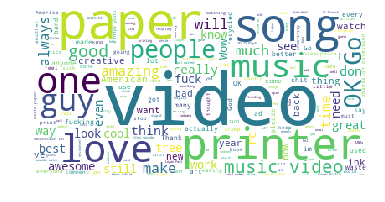

In [95]:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()